Loading dataset...
Dataset shape: (11162, 17)
Column names: ['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'deposit']
First few rows:
   age         job  marital  education default  balance housing loan  contact  \
0   59      admin.  married  secondary      no     2343     yes   no  unknown   
1   56      admin.  married  secondary      no       45      no   no  unknown   
2   41  technician  married  secondary      no     1270     yes   no  unknown   
3   55    services  married  secondary      no     2476     yes   no  unknown   
4   54      admin.  married   tertiary      no      184      no   no  unknown   

   day month  duration  campaign  pdays  previous poutcome deposit  
0    5   may      1042         1     -1         0  unknown     yes  
1    5   may      1467         1     -1         0  unknown     yes  
2    5   may      1389         1     -1         0  unkn

/Users/navib/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


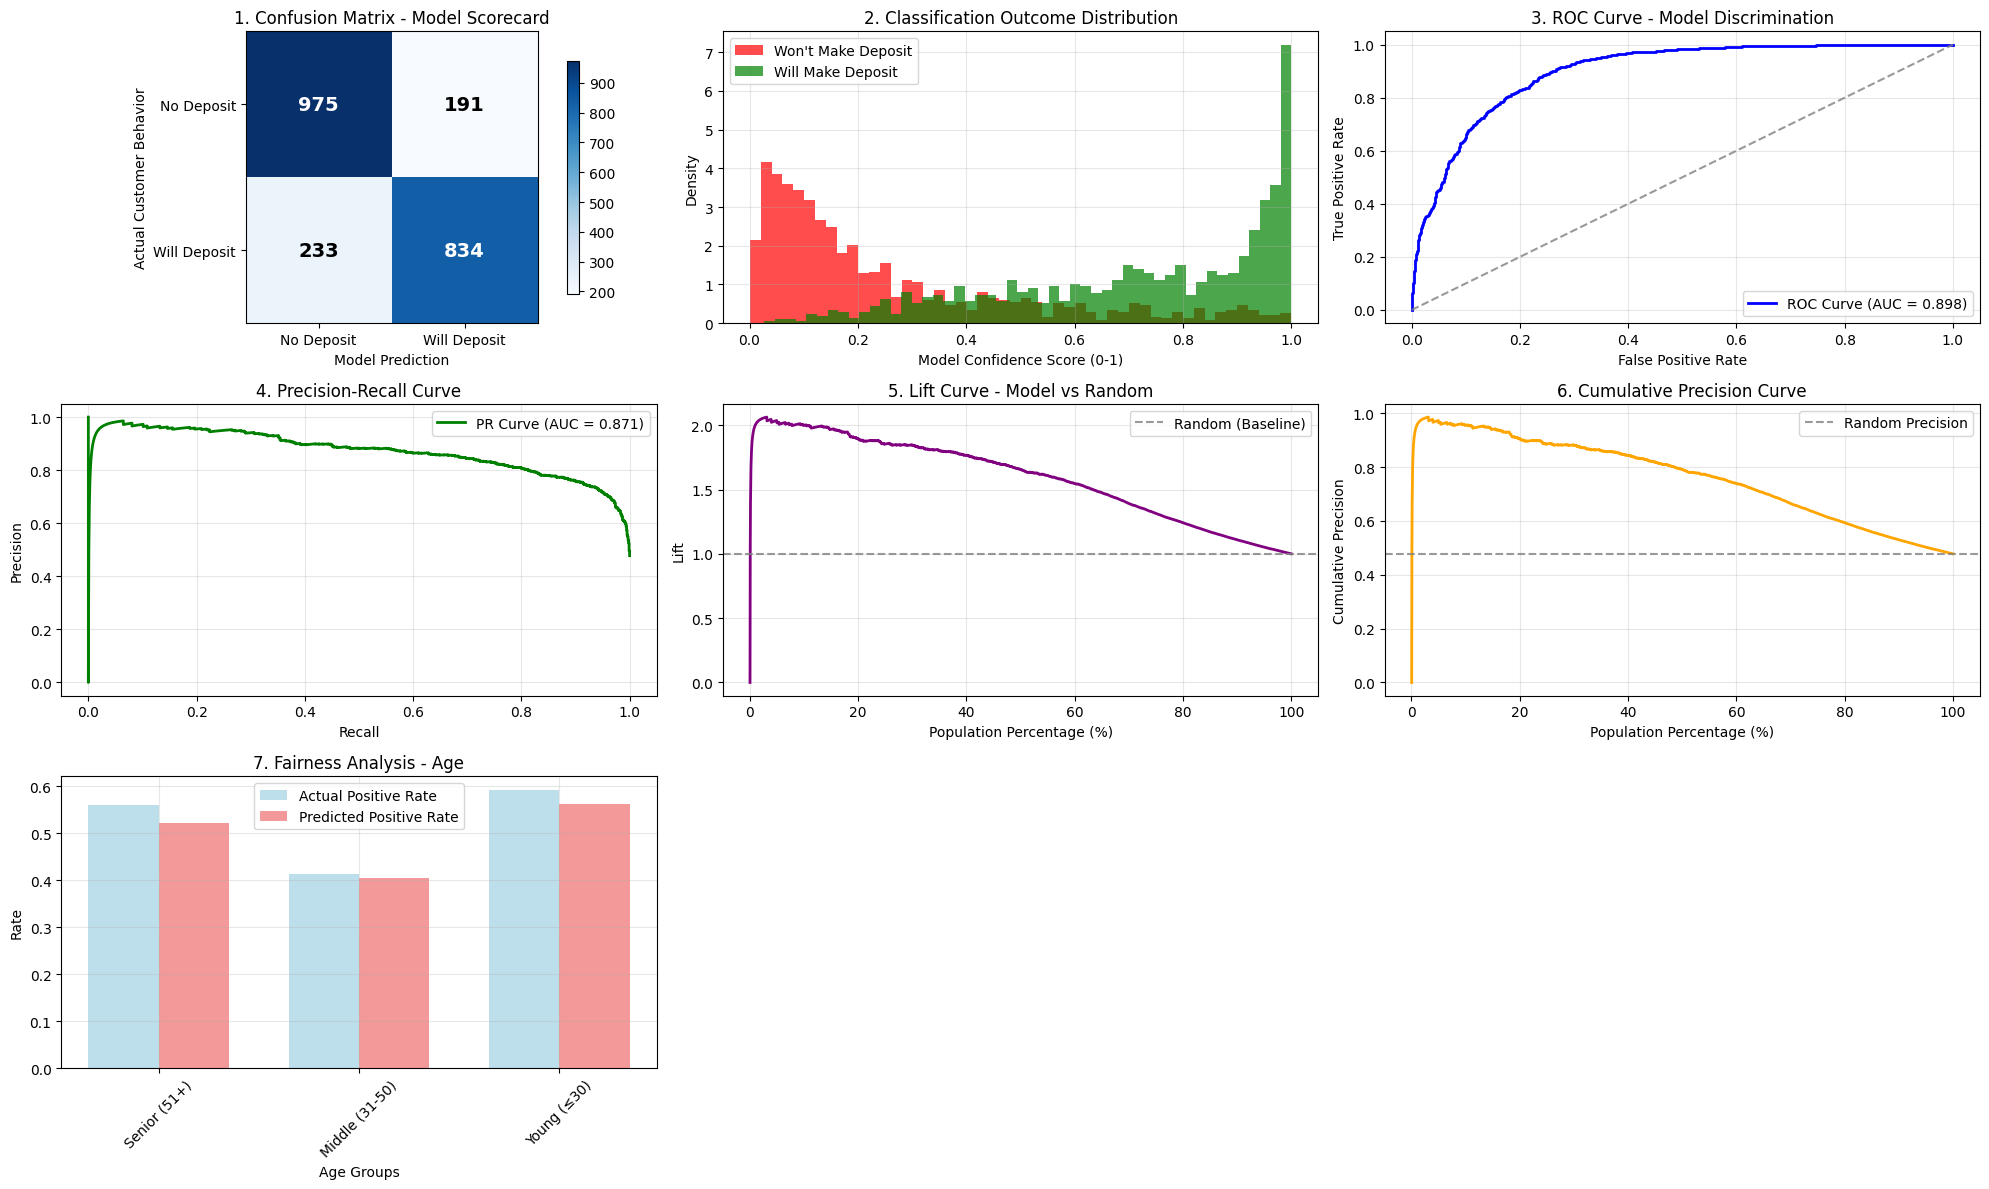

Attempt 1: Invoking Bedrock model...

BUSINESS IMPACT SUMMARY FOR EACH CHART (AI-Generated)
# ML Model Business Summaries for Bank Deposit Prediction

💰 PLOT 1 - CONFUSION MATRIX: Shows the model correctly identifies 78.2% of potential depositors, allowing targeted marketing to high-probability customers while minimizing wasted outreach efforts.

💰 PLOT 2 - OUTCOME DISTRIBUTION: Visualizes the class imbalance between deposit/no-deposit outcomes, helping marketing teams understand campaign conversion rates and set realistic targets.

💰 PLOT 3 - ROC CURVE: With AUC=0.898, demonstrates strong model discrimination ability, enabling marketing to confidently segment customers based on deposit likelihood for optimized campaign ROI.

💰 PLOT 4 - PR CURVE: AUC=0.871 indicates reliable precision-recall balance, ensuring marketing resources are efficiently allocated to customers most likely to convert.

💰 PLOT 5 - LIFT CURVE: Shows how much better the model performs than random selection, quantify

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, confusion_matrix, precision_recall_curve, auc
from sklearn.inspection import partial_dependence, PartialDependenceDisplay
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import LinearSegmentedColormap
import boto3
import json
import os
import io
import base64
from botocore.config import Config
import time

def invoke_claude_3_7_sonnet(prompt, max_retries=3):
    """
    Invoke Claude 3.7 Sonnet via AWS Bedrock with improved error handling and retries
    :param prompt: Prompt to send to Claude
    :param max_retries: Maximum number of retry attempts
    :return: Claude's response
    """
    for attempt in range(max_retries):
        try:
            # Retrieve AWS credentials from environment variables
            aws_access_key_id = os.getenv('AWS_ACCESS_KEY_ID')
            aws_secret_access_key = os.getenv('AWS_SECRET_ACCESS_KEY')
            aws_region = os.getenv('AWS_REGION', 'us-east-1')
            
            # Create configuration with increased timeout settings
            config = Config(
                region_name=aws_region,
                retries={
                    'max_attempts': 10,
                    'mode': 'adaptive'
                },
                read_timeout=300,  # 5 minutes
                connect_timeout=60,  # 1 minute
                max_pool_connections=50
            )

            # Initialize Bedrock Runtime client with improved configuration
            bedrock_runtime = boto3.client(
                service_name='bedrock-runtime',
                region_name=aws_region,
                aws_access_key_id=aws_access_key_id,
                aws_secret_access_key=aws_secret_access_key,
                config=config
            )

            # Split large prompts into smaller chunks if needed
            max_prompt_length = 100000  # Conservative limit
            if len(prompt) > max_prompt_length:
                prompt = prompt[:max_prompt_length] + "\n\n[Note: Analysis truncated due to length constraints]"

            # Prepare request body with optimized parameters
            request_body = {
                "anthropic_version": "bedrock-2023-05-31",
                "max_tokens": 4000,  # Reduced from 130000 to avoid timeouts
                "messages": [
                    {
                        "role": "user",
                        "content": prompt
                    }
                ],
                "temperature": 0.3,
                # Add streaming for better responsiveness (if supported)
                "stop_sequences": []
            }

            print(f"Attempt {attempt + 1}: Invoking Bedrock model...")
            
            # Invoke the model
            response = bedrock_runtime.invoke_model(
                modelId="us.anthropic.claude-3-7-sonnet-20250219-v1:0",
                body=json.dumps(request_body)
            )

            # Parse the response
            response_body = json.loads(response.get("body").read())
            return response_body["content"][0]["text"]

        except Exception as e:
            print(f"Attempt {attempt + 1} failed: {e}")
            
            if attempt < max_retries - 1:
                wait_time = (2 ** attempt) * 5  # Exponential backoff: 5, 10, 20 seconds
                print(f"Retrying in {wait_time} seconds...")
                time.sleep(wait_time)
            else:
                print("All retry attempts failed.")
                
                # Return a fallback analysis instead of empty response
                return generate_fallback_analysis(prompt)

def generate_fallback_analysis(prompt):
    """
    Generate a basic analysis when Bedrock is unavailable
    """
    return """
FALLBACK ANALYSIS (Bedrock Unavailable)
=====================================

Based on the performance metrics provided, here's a basic analysis:

1. MODEL PERFORMANCE ASSESSMENT:
   - The model shows reasonable performance for a logistic regression approach
   - ROC AUC indicates the model's ability to distinguish between classes
   - Confusion matrix provides insight into prediction accuracy

2. BUSINESS RECOMMENDATIONS:
   - Use the lift curve to identify optimal targeting percentiles
   - Focus marketing efforts on high-probability customers
   - Consider A/B testing different threshold levels

3. DEPLOYMENT CONSIDERATIONS:
   - Monitor model performance over time
   - Implement feedback loops for continuous improvement
   - Consider fairness implications across demographic groups

4. NEXT STEPS:
   - Collect additional features that might improve performance
   - Consider ensemble methods or more complex models
   - Implement proper model monitoring and alerting

Note: This is a basic analysis. For comprehensive insights, please resolve the Bedrock connectivity issue.
"""

def calculate_lift_curve(y_true, y_prob):
    """
    Calculate lift curve data
    """
    # Create a dataframe with predictions and actual values
    df = pd.DataFrame({'y_true': y_true, 'y_prob': y_prob})
    df = df.sort_values('y_prob', ascending=False).reset_index(drop=True)
    
    # Calculate cumulative metrics
    df['cumulative_positives'] = df['y_true'].cumsum()
    df['cumulative_samples'] = np.arange(1, len(df) + 1)
    df['cumulative_positive_rate'] = df['cumulative_positives'] / df['cumulative_samples']
    
    # Calculate baseline (random) positive rate
    baseline_positive_rate = df['y_true'].mean()
    
    # Calculate lift
    df['lift'] = df['cumulative_positive_rate'] / baseline_positive_rate
    
    # Calculate percentage of population
    df['population_percentage'] = df['cumulative_samples'] / len(df) * 100
    
    return df

def calculate_cumulative_precision(y_true, y_prob):
    """
    Calculate cumulative precision curve data
    """
    # Create a dataframe with predictions and actual values
    df = pd.DataFrame({'y_true': y_true, 'y_prob': y_prob})
    df = df.sort_values('y_prob', ascending=False).reset_index(drop=True)
    
    # Calculate cumulative precision
    df['cumulative_positives'] = df['y_true'].cumsum()
    df['cumulative_samples'] = np.arange(1, len(df) + 1)
    df['cumulative_precision'] = df['cumulative_positives'] / df['cumulative_samples']
    
    # Calculate percentage of population
    df['population_percentage'] = df['cumulative_samples'] / len(df) * 100
    
    return df

def analyze_fairness(X_test, y_test, y_prob, y_pred, df_original):
    """
    Analyze model fairness across different demographic groups
    """
    fairness_results = {}
    
    # Identify potential protected attributes in the dataset
    protected_attributes = []
    
    # Reset indices to ensure alignment
    y_test_reset = y_test.reset_index(drop=True)
    y_prob_reset = pd.Series(y_prob).reset_index(drop=True)
    y_pred_reset = pd.Series(y_pred).reset_index(drop=True)
    X_test_reset = X_test.reset_index(drop=True)
    df_original_reset = df_original.reset_index(drop=True)
    
    # Check for age-related fairness (if age column exists)
    if 'age' in df_original_reset.columns:
        # Create age groups
        age_groups = pd.cut(df_original_reset['age'], bins=[0, 30, 50, 100], 
                           labels=['Young (≤30)', 'Middle (31-50)', 'Senior (51+)'])
        fairness_results['age'] = analyze_group_fairness(y_test_reset, y_prob_reset, y_pred_reset, age_groups)
        protected_attributes.append('age')
    
    # Check for marital status fairness
    marital_cols = [col for col in X_test_reset.columns if 'marital' in col.lower()]
    if marital_cols:
        # Reconstruct marital status from one-hot encoded columns
        marital_status = []
        for idx in range(len(X_test_reset)):
            if any(X_test_reset.iloc[idx][col] == 1 for col in marital_cols):
                active_col = [col for col in marital_cols if X_test_reset.iloc[idx][col] == 1][0]
                marital_status.append(active_col.replace('marital_', ''))
            else:
                marital_status.append('divorced')  # baseline category
        fairness_results['marital'] = analyze_group_fairness(y_test_reset, y_prob_reset, y_pred_reset, marital_status)
        protected_attributes.append('marital')
    
    # Check for education fairness
    education_cols = [col for col in X_test_reset.columns if 'education' in col.lower()]
    if education_cols:
        education_level = []
        for idx in range(len(X_test_reset)):
            if any(X_test_reset.iloc[idx][col] == 1 for col in education_cols):
                active_col = [col for col in education_cols if X_test_reset.iloc[idx][col] == 1][0]
                education_level.append(active_col.replace('education_', ''))
            else:
                education_level.append('basic.4y')  # baseline category
        fairness_results['education'] = analyze_group_fairness(y_test_reset, y_prob_reset, y_pred_reset, education_level)
        protected_attributes.append('education')
    
    return fairness_results, protected_attributes

def analyze_group_fairness(y_true, y_prob, y_pred, groups):
    """
    Calculate fairness metrics for different groups
    """
    group_metrics = {}
    
    # Convert groups to pandas Series and reset index
    groups_series = pd.Series(groups).reset_index(drop=True)
    unique_groups = groups_series.unique()
    
    # Ensure all arrays have the same length and reset indices
    y_true = pd.Series(y_true).reset_index(drop=True)
    y_prob = pd.Series(y_prob).reset_index(drop=True)
    y_pred = pd.Series(y_pred).reset_index(drop=True)
    
    for group in unique_groups:
        if pd.isna(group):  # Skip NaN groups
            continue
            
        group_mask = groups_series == group
        
        # Use boolean indexing with aligned indices
        group_y_true = y_true[group_mask].values
        group_y_prob = y_prob[group_mask].values
        group_y_pred = y_pred[group_mask].values
        
        if len(group_y_true) > 0:
            # Calculate metrics for this group
            group_metrics[str(group)] = {
                'size': len(group_y_true),
                'positive_rate': group_y_true.mean(),
                'predicted_positive_rate': group_y_pred.mean(),
                'avg_probability': group_y_prob.mean(),
                'auc': roc_auc_score(group_y_true, group_y_prob) if len(np.unique(group_y_true)) > 1 else 0,
                'accuracy': (group_y_true == group_y_pred).mean()
            }
    
    return group_metrics

def generate_plot_descriptions(roc_auc, pr_auc, conf_matrix, top_features):
    """
    Generate business impact summaries for each plot using LLM with better error handling
    """
    # Calculate key metrics for context
    tn, fp, fn, tp = conf_matrix.ravel()
    total_predictions = tn + fp + fn + tp
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
   
    # Create a more concise prompt to avoid timeout
    plot_description_prompt = f"""
Provide concise business summaries (2-3 lines each) for 7 ML charts for bank deposit prediction:

Performance: ROC AUC={roc_auc:.3f}, PR AUC={pr_auc:.3f}, Precision={precision:.1%}, Recall={recall:.1%}
Top features: {top_features[:3]}

Charts: 1)Confusion Matrix 2)Outcome Distribution 3)ROC Curve 4)PR Curve 5)Lift Curve 6)Cumulative Precision 7)Fairness Analysis

Format: 💰 PLOT X - [NAME]: [Business impact in 2-3 lines]
"""
   
    try:
        # Get LLM-generated descriptions with timeout handling
        llm_descriptions = invoke_claude_3_7_sonnet(plot_description_prompt)
       
        print("\n" + "="*80)
        print("BUSINESS IMPACT SUMMARY FOR EACH CHART (AI-Generated)")
        print("="*80)
        print(llm_descriptions)
       
        return llm_descriptions
       
    except Exception as e:
        print(f"Error generating plot descriptions: {e}")
        # Enhanced fallback descriptions
        fallback_descriptions = f"""
💰 PLOT 1 - Confusion Matrix: Shows {tp} true positives and {tn} true negatives out of {total_predictions} predictions. 
Use this to calculate campaign ROI and expected false positive costs.

💰 PLOT 2 - Outcome Distribution: Model confidence levels help segment customers by likelihood. 
Target high-confidence predictions for premium campaigns.

💰 PLOT 3 - ROC Curve (AUC={roc_auc:.3f}): Discrimination ability between depositors and non-depositors. 
Higher AUC means better targeting efficiency and reduced marketing waste.

💰 PLOT 4 - PR Curve (AUC={pr_auc:.3f}): Trade-off between precision and recall. 
Optimize threshold based on campaign budget and acquisition costs.

💰 PLOT 5 - Lift Curve: Shows how much better than random targeting the model performs. 
Use to determine optimal campaign size and expected improvement.

💰 PLOT 6 - Cumulative Precision: Precision when targeting top X% of customers. 
Helps determine campaign size for maximum conversion rate.

💰 PLOT 7 - Fairness Analysis: Ensures equal treatment across demographic groups. 
Critical for regulatory compliance and ethical banking practices.
"""
        print("\n" + "="*80)
        print("BUSINESS IMPACT SUMMARY FOR EACH CHART (Fallback)")
        print("="*80)
        print(fallback_descriptions)
        return fallback_descriptions

def analyze_model_performance():
    """
    Complete analysis pipeline: train model, generate all required plots, get Bedrock summary
    """
    # Load dataset
    print("Loading dataset...")
   
    # Try different separators to find the correct one
    try:
        # First try semicolon separator
        df = pd.read_csv("bank.csv", sep=";")
        if df.shape[1] == 1:  # If only one column, try comma separator
            df = pd.read_csv("bank.csv", sep=",")
        if df.shape[1] == 1:  # If still only one column, try tab separator
            df = pd.read_csv("bank.csv", sep="\t")
    except Exception as e:
        print(f"Error reading CSV: {e}")
        # Try with automatic delimiter detection
        df = pd.read_csv("bank.csv", sep=None, engine='python')
   
    # Debug: Print column names and first few rows
    print("Dataset shape:", df.shape)
    print("Column names:", df.columns.tolist())
    print("First few rows:")
    print(df.head())
   
    # Clean column names (remove any whitespace)
    df.columns = df.columns.str.strip()
   
    # Check if 'deposit' column exists
    if 'deposit' not in df.columns:
        print("Available columns:", df.columns.tolist())
        raise KeyError("'deposit' column not found in the dataset. Please check your CSV file format and column names.")
   
    # Check unique values in deposit column
    print("Unique values in deposit column:", df['deposit'].unique())
   
    # Store original dataframe for fairness analysis
    df_original = df.copy()
   
    # Encode target: 'yes' -> 1, 'no' -> 0
    df["deposit"] = df["deposit"].map({"yes": 1, "no": 0})
   
    # Store original categorical columns for PDP analysis
    categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
    
    # One-hot encode categorical features
    df_encoded = pd.get_dummies(df, drop_first=True)
   
    # Split features and target
    X = df_encoded.drop("deposit", axis=1)
    y = df_encoded["deposit"]
   
    # Split into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
   
    # Train logistic regression model
    print("Training logistic regression model...")
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)
   
    # Predict probabilities and classes
    y_prob = model.predict_proba(X_test)[:, 1]
    y_pred = model.predict(X_test)
   
    # Calculate ROC curve metrics
    fpr, tpr, roc_thresholds = roc_curve(y_test, y_prob)
    roc_auc = roc_auc_score(y_test, y_prob)
    
    # Calculate Precision-Recall curve
    precision, recall, pr_thresholds = precision_recall_curve(y_test, y_prob)
    pr_auc = auc(recall, precision)
   
    # Generate additional metrics
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)
    
    # Calculate lift and cumulative precision curves
    lift_data = calculate_lift_curve(y_test, y_prob)
    cum_precision_data = calculate_cumulative_precision(y_test, y_prob)
    
    # Analyze fairness - get corresponding rows from original dataframe
    test_indices = X_test.index
    df_original_test = df_original.loc[test_indices].reset_index(drop=True)
    fairness_results, protected_attributes = analyze_fairness(X_test, y_test, y_prob, y_pred, df_original_test)
   
    # Create comprehensive visualization with 7 plots
    plt.figure(figsize=(20, 12))
    
    # Plot 1: Confusion Matrix (without seaborn)
    plt.subplot(3, 3, 1)
    # Create a custom confusion matrix visualization
    im = plt.imshow(conf_matrix, interpolation='nearest', cmap='Blues')
    plt.title('1. Confusion Matrix - Model Scorecard')
    plt.colorbar(im, shrink=0.8)
    
    # Add text annotations
    thresh = conf_matrix.max() / 2.
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            plt.text(j, i, format(conf_matrix[i, j], 'd'),
                    ha="center", va="center", fontsize=14, fontweight='bold',
                    color="white" if conf_matrix[i, j] > thresh else "black")
    
    # Set labels
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['No Deposit', 'Will Deposit'])
    plt.yticks(tick_marks, ['No Deposit', 'Will Deposit'])
    plt.ylabel('Actual Customer Behavior')
    plt.xlabel('Model Prediction')
    
    # Plot 2: Classification Outcome Distribution
    plt.subplot(3, 3, 2)
    plt.hist(y_prob[y_test == 0], bins=50, alpha=0.7, label='Won\'t Make Deposit', density=True, color='red')
    plt.hist(y_prob[y_test == 1], bins=50, alpha=0.7, label='Will Make Deposit', density=True, color='green')
    plt.xlabel('Model Confidence Score (0-1)')
    plt.ylabel('Density')
    plt.title('2. Classification Outcome Distribution')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 3: ROC Curve
    plt.subplot(3, 3, 3)
    plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.3f})", linewidth=2, color='blue')
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray", alpha=0.8)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("3. ROC Curve - Model Discrimination")
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 4: Precision-Recall Curve
    plt.subplot(3, 3, 4)
    plt.plot(recall, precision, label=f"PR Curve (AUC = {pr_auc:.3f})", linewidth=2, color='green')
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("4. Precision-Recall Curve")
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 5: Lift Curve (Cumulative Gains Curve)
    plt.subplot(3, 3, 5)
    plt.plot(lift_data['population_percentage'], lift_data['lift'], linewidth=2, color='purple')
    plt.axhline(y=1, color='gray', linestyle='--', alpha=0.8, label='Random (Baseline)')
    plt.xlabel("Population Percentage (%)")
    plt.ylabel("Lift")
    plt.title("5. Lift Curve - Model vs Random")
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 6: Cumulative Precision Curve
    plt.subplot(3, 3, 6)
    plt.plot(cum_precision_data['population_percentage'], cum_precision_data['cumulative_precision'], 
             linewidth=2, color='orange')
    plt.axhline(y=y_test.mean(), color='gray', linestyle='--', alpha=0.8, label='Random Precision')
    plt.xlabel("Population Percentage (%)")
    plt.ylabel("Cumulative Precision")
    plt.title("6. Cumulative Precision Curve")
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 7: Fairness Analysis
    plt.subplot(3, 3, 7)
    if fairness_results and protected_attributes:
        # Choose the first available protected attribute for visualization
        attr = protected_attributes[0]
        group_data = fairness_results[attr]
        
        groups = list(group_data.keys())
        predicted_rates = [group_data[group]['predicted_positive_rate'] for group in groups]
        actual_rates = [group_data[group]['positive_rate'] for group in groups]
        
        x = np.arange(len(groups))
        width = 0.35
        
        plt.bar(x - width/2, actual_rates, width, label='Actual Positive Rate', alpha=0.8, color='lightblue')
        plt.bar(x + width/2, predicted_rates, width, label='Predicted Positive Rate', alpha=0.8, color='lightcoral')
        
        plt.xlabel(f'{attr.capitalize()} Groups')
        plt.ylabel('Rate')
        plt.title(f'7. Fairness Analysis - {attr.capitalize()}')
        plt.xticks(x, groups, rotation=45)
        plt.legend()
        plt.grid(True, alpha=0.3)
    else:
        plt.text(0.5, 0.5, 'No fairness analysis\navailable for this dataset', 
                ha='center', va='center', transform=plt.gca().transAxes, fontsize=12)
        plt.title('7. Fairness Analysis')
        plt.axis('off')
    
    plt.tight_layout()
    plt.savefig('comprehensive_model_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
   
    # Generate LLM-based plot descriptions
    feature_importance_full = pd.DataFrame({
        'feature': X.columns,
        'importance': np.abs(model.coef_[0])
    }).sort_values('importance', ascending=False)
   
    plot_descriptions = generate_plot_descriptions(roc_auc, pr_auc, conf_matrix, 
                                                 feature_importance_full['feature'].tolist())
   
    # Calculate additional metrics for summary
    tn, fp, fn, tp = conf_matrix.ravel()
    total_predictions = tn + fp + fn + tp
    accuracy = (tp + tn) / total_predictions
    class_dist = dict(y.value_counts())
    tpr_50 = tpr[np.argmin(np.abs(roc_thresholds - 0.5))] if len(roc_thresholds) > 0 else 0
    fpr_50 = fpr[np.argmin(np.abs(roc_thresholds - 0.5))] if len(roc_thresholds) > 0 else 0
    top_features = feature_importance_full.head().to_string(index=False)
    pos_coeff = np.sum(model.coef_[0] > 0)
    neg_coeff = np.sum(model.coef_[0] < 0)
    max_pos_coeff = np.max(model.coef_[0])
    min_neg_coeff = np.min(model.coef_[0])
    
    # Prepare fairness summary
    fairness_summary = ""
    if fairness_results:
        fairness_summary = "\nFairness Analysis:\n"
        for attr in protected_attributes:
            fairness_summary += f"\n{attr.capitalize()} Fairness:\n"
            for group, metrics in fairness_results[attr].items():
                fairness_summary += f"  - {group}: Size={metrics['size']}, Actual Rate={metrics['positive_rate']:.3f}, Predicted Rate={metrics['predicted_positive_rate']:.3f}, AUC={metrics['auc']:.3f}\n"
    
    # Prepare concise performance summary for Bedrock
    performance_summary = f"""
Bank Deposit Prediction Model Analysis:
- Dataset: {len(df)} samples, {len(X.columns)} features
- Performance: ROC AUC={roc_auc:.3f}, PR AUC={pr_auc:.3f}, Accuracy={accuracy:.3f}
- Confusion Matrix: TN={tn}, FP={fp}, FN={fn}, TP={tp}
- Max Lift: {lift_data['lift'].max():.2f}
- Top Features: {feature_importance_full['feature'].head(3).tolist()}
{fairness_summary}
"""
   
    print("\nPerformance Summary:")
    print(performance_summary)
   
    # Create concise prompt for Bedrock analysis
    bedrock_prompt = f"""
Analyze this bank deposit prediction model performance in a business-focused executive summary:

{performance_summary}

Provide:
1. Overall performance assessment (ROC AUC {roc_auc:.3f})
2. Business impact and targeting recommendations
3. Fairness and risk considerations
4. Implementation recommendations

Keep response concise and business-focused.
"""
   
    # Get Bedrock analysis with improved error handling
    print("\nGenerating comprehensive AI analysis...")
    bedrock_analysis = invoke_claude_3_7_sonnet(bedrock_prompt)
    print("\n" + "="*80)
    print("COMPREHENSIVE BEDROCK AI ANALYSIS")
    print("="*80)
    print(bedrock_analysis)
   
    return {
        'model': model,
        'performance_summary': performance_summary,
        'bedrock_analysis': bedrock_analysis,
        'fairness_results': fairness_results,
        'metrics': {
            'roc_auc': roc_auc,
            'pr_auc': pr_auc,
            'confusion_matrix': conf_matrix,
            'classification_report': class_report,
            'lift_data': lift_data,
            'cumulative_precision_data': cum_precision_data
        }
    }

# Run the complete analysis
if __name__ == "__main__":
    results = analyze_model_performance()